# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
%matplotlib inline

In [3]:
filename = 'segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord'
datasetSingleID = get_dataset("/home/workspace/nd013-c1-vision-starter/data/train/%s"%filename)
filename = '*'
datasetALL = get_dataset("/home/workspace/nd013-c1-vision-starter/data/train/*")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/nd013-c1-vision-starter/data/train/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/nd013-c1-vision-starter/data/train/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()
INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/nd013-c1-vision-starter/data/train/*']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/nd013-c1-vision-starter/data/train/*']
INFO:tensorflow:Number of filenames to read: 86


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [4]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    
    # color mapping of classes
    # red cars, green ped-ns, blue - cy-sts
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}

    f, ax = plt.subplots(2, 5, figsize=(20, 10))
    
    for idx,example in enumerate(batch):
        x = idx % 2
        y = idx % 5
    
        im_width, im_height = example["original_image_spatial_shape"]
    
        ax[x, y].imshow(example["image"].numpy())
    
        bboxes  = example["groundtruth_boxes"]
        classes = example["groundtruth_classes"]
        for cl, bb in zip(classes, bboxes):
            y1, x1, y2, x2 = bb.numpy()
            x1, x2, y1, y2 = x1 * im_width.numpy(),  x2 * im_width.numpy(),\
                             y1 * im_height.numpy(), y2 * im_height.numpy()
            
            rec = Rectangle((x1, y1), (x2-x1), (y2-y1), facecolor='none', 
                            edgecolor=colormap[cl.numpy()])
            ax[x, y].add_patch(rec)
        ax[x ,y].axis('off')
            
    plt.tight_layout()
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

single print ID


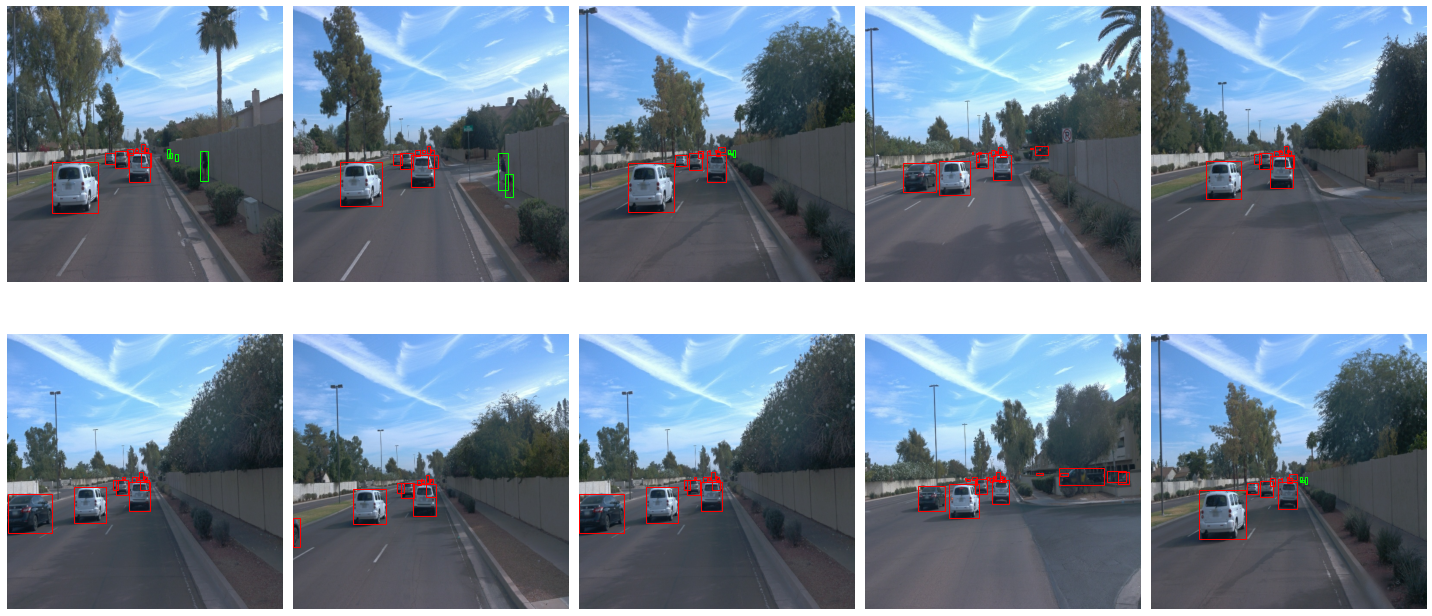

all


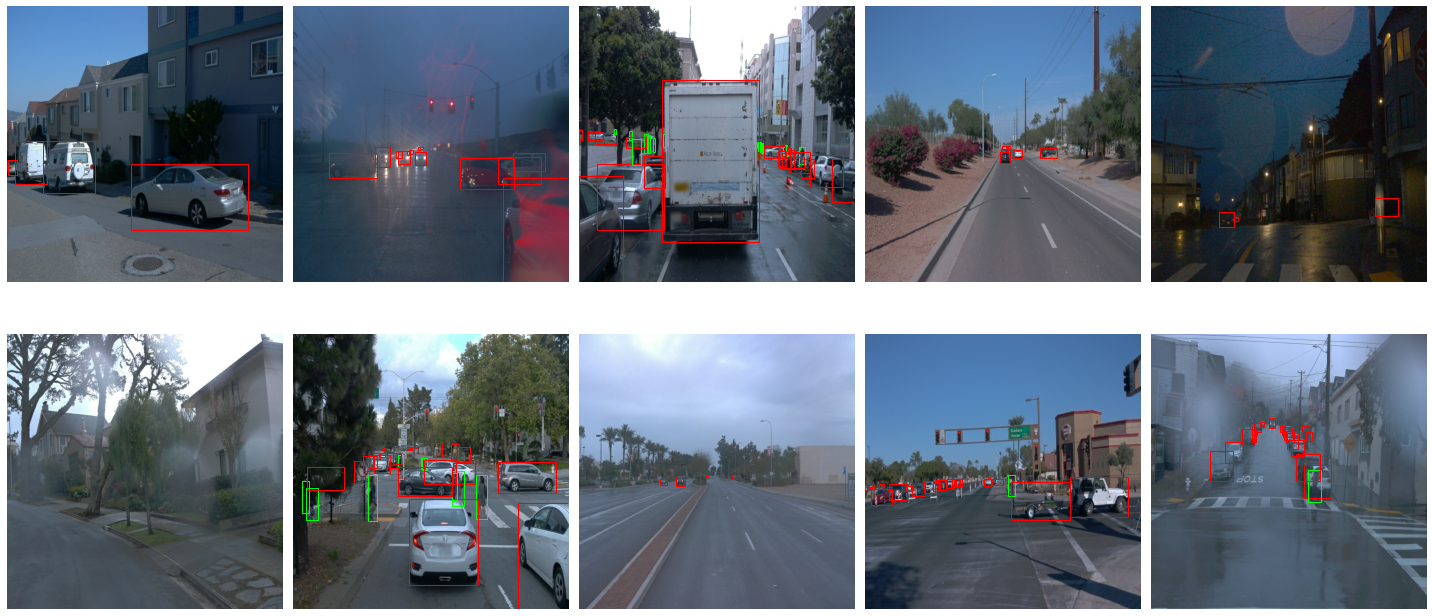

In [6]:
keep_same_frames = False

buffer_size = 100  
batch_size  = 10

if keep_same_frames:
    batch = datasetSingleID.take(batch_size) # the frames are shuffled between runs
else:
    batch = datasetSingleID.shuffle(buffer_size)
    batch = batch.take(batch_size)


print('single print ID')
display_instances(batch)
print('all')
display_instances(datasetALL.shuffle(buffer_size).take(batch_size))

# First-pass EDA
Single file contains frames from the same trip. Thus, when splitting into training, validation and test datasets we need to split by the trip ID and do not mix frames from the same trip between training, validation, testing. Otherwise, data leakage will occur. The data has been split by IDs for us already. 

Large variability between weather conditions, times of day can be noticed. Some bboxes seem to be low quality: not perfect non-max suppression results can be seen for some frames (two high IoU boxes bounding the same object), some boxes are really small and correspond to objects heavily obstructed by non-target objects, e.g., trees. 

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [13]:
from collections import Counter

all_classes = []

number_of_frames = 10000
buffer_of_frames = number_of_frames*2

for j,ex in enumerate(datasetALL.shuffle(buffer_of_frames).take(number_of_frames)):
    classes = ex["groundtruth_classes"]
    all_classes.extend(classes.numpy())

classVariation = Counter(all_classes)
    
print('Among %d random frames'%(j+1))
print('there were %d cars, %d pedestrians, %d bicycles'%(classVariation[1],classVariation[2],classVariation[4]))

Among 10000 random frames
there were 173418 cars, 49672 pedestrians, 1284 bicycles


Based on the result above the dataset is predominated by cars, has a fair amount of pedestrians but bicycles are relatively rare. Thus, some class imbalance seems to be present. 